In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

stock_code = pd.read_csv('./data/data.csv', encoding='cp949')
stock_code = {i:j for i,j in zip(stock_code.종목코드.map(lambda x : '{:06d}'.format(x)), stock_code.종목명)}

import warnings
warnings.filterwarnings('ignore')

import pickle
with open('raw_data_20190115.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)

In [146]:
copy_keys = list(raw_data.keys())
for stock in copy_keys:
    if len(raw_data[stock].loc[:'2010-01-01']) < 1:
        del raw_data[stock]
        print(stock)

BGF
BGF리테일
BNK금융지주
GS리테일
HDC현대산업개발
LIG넥스원
SK케미칼
넷마블
동아에스티
두산밥캣
락앤락
롯데하이마트
만도
삼성물산
삼성바이오로직스
삼성생명
삼성에스디에스
오리온
이노션
이마트
일진머티리얼즈
종근당
코스맥스
코오롱인더
쿠쿠홀딩스
한국콜마
한국타이어
한국항공우주
한라홀딩스
한미약품
한화생명
현대로템
현대위아
현대중공업지주
현대홈쇼핑
효성중공업


In [9]:
len(raw_data)

166

In [147]:
# stock에서 Volume==0인 index, stock에서 제외
for key, df in raw_data.items():
    raw_data[key] = df.drop(df.index[np.where(df.Volume==0)[0]], axis=0)
    del raw_data[key]['Adj Close']

In [148]:
import gc
import os
import tqdm
import logging
import datetime
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,StratifiedKFold

In [149]:
def get_MACD(df, short_ma=12, long_ma=26, signal_period=9):
    ewm_12 = df['Close'].ewm(span = short_ma, min_periods = short_ma - 1).mean()
    ewm_26 = df['Close'].ewm(span = long_ma, min_periods = long_ma - 1).mean()
    df['MACD'] = ewm_12 - ewm_26
    df['MACDSignal'] = df['MACD'].ewm(span = signal_period, min_periods = signal_period-1).mean()
    df['MACDDiff'] = df['MACD'] - df['MACDSignal']
    return df

def get_Stochastic(df, n=14):
    df['sto_K_{}'.format(n)] = 100 * ((df.Close - df.Low.rolling(n).min()) / 
                                      (df.High.rolling(n).max() - df.Low.rolling(n).min()))
    df['sto_D_{}'.format(n)] = df['sto_K_{}'.format(n)].rolling(3).mean()
    return df
    
def get_RSI(df, n=14):
    U = np.where(df['Close'].diff(1)>0, df['Close'].diff(1), 0)
    D = np.where(df['Close'].diff(1)<0, df['Close'].diff(1)*(-1), 0)
    
    AU = pd.Series(U).rolling(window=n, min_periods=n).mean()
    AD = pd.Series(D).rolling(window=n, min_periods=n).mean()
    
    RSI = AU.div(AD+AU) * 100
    df['RSI_{}'.format(n)] = RSI.values
    return df
    
def get_BolingerBand(df, n=20, k=2):
    df = df.assign(BolingerCenter = df['Close'].rolling(window=n).mean())
    df = df.assign(Bol_upper = df['Close'].rolling(window=n).mean() + k*df['Close'].rolling(window=n).std())
    df = df.assign(Bol_lower = df['Close'].rolling(window=n).mean() - k*df['Close'].rolling(window=n).std())
    return df

def get_SMA(df, window):
    df['close_ma_{}'.format(window)] = df['Close'].rolling(window).mean()
    return df
    
def get_EMA(df, window):
    df['close_ema_{}'.format(window)] = df['Close'].ewm(span=window).mean()
    return df
    
def get_RoC(df, periods):
    df['roc_{}'.format(periods)] = df['Close'].pct_change(periods=periods)
    return df
    
def get_CV(df, window):
    df['his_vol_{}'.format(window)] = np.log(df['Close'] / df['Close'].shift(1)).rolling(window).std()*(252**0.5)
    return df
    
def get_WilliamR(df, n):
    W_R = -100 * ((df.High.rolling(n).max() - df.Close) / (df.High.rolling(n).max() - df.Low.rolling(n).min()))
    df['WR_{}'.format(n)] = W_R
    return df
    
def get_CCI(df, window):
    TP = (df.Close + df.Low + df.High) / 3
    dataX = []
    for i in range(len(TP) - window+1):
        a = TP.values[i:(i+window)]
        dataX.append(a)
    dataMean = [i.mean() for i in dataX]
    AVEDEV = [abs(x - mean).mean() for x, mean 
              in zip(dataX, dataMean)]
    for i in range(window-1):
        AVEDEV.insert(0,np.nan)
    AVEDEV = pd.Series(AVEDEV, index = TP.index)
    CCI = (TP - TP.rolling(20).mean()) / (0.015 * AVEDEV)
    df['CCI_{}'.format(window)] = CCI
    return df
    
def get_DI(df, window):
    df['DI_{}'.format(window)] = 100 * ((df.Close - df.Close.rolling(window).mean()) / df.Close.rolling(window).mean())
    return df

def get_VPT(df):
    df['VPT'] = ((test.Close.diff(1) / test.Close) * test.Volume).cumsum()
    return df
    
def get_MA_diff(df, window):
    df['ma_diff_{}'.format(window)] = df['Close'].rolling(window).mean() - df['Close'].shift(window).rolling(window).mean()
    return df

def get_MA_n_diff(df, n, window):
    df['ma_{}_diff_{}'.format(n, window)] = df['Close'].rolling(window).mean() - df['Close'].rolling(window+n).mean()
    return df
    
def get_OBV(df):
    df['OBV'] = (np.sign(df['Close'].diff(1).fillna(0)) * df['Volume']).cumsum()
    return df

def get_VolMA(df, window):
    df['volume_ma_{}'.format(window)] = df['Volume'].rolling(window).mean()
    return df

def get_LogReturns(df, window, Prev, Next):
    text = Prev[0] + Next[0]
    df['returns{}{}'.format(text, window) ]= np.log(df[Next] /
                                                    df[Prev].shift(window))

In [150]:
from tqdm import tqdm_notebook

In [151]:
for key, df in tqdm_notebook(raw_data.items()):
    for window in range(1, 91,3):
        raw_data[key] = get_SMA(df, window)
        raw_data[key] = get_VolMA(df, window)
        raw_data[key] = get_EMA(df, window)
    n = 10
    for window in range(1, 91,3):
        raw_data[key] = get_MA_diff(df, window)
        raw_data[key] = get_MA_n_diff(df, n, window)
    for window in range(1, 91,3):
        raw_data[key] = get_CV(df, window)
    for window in range(1, 91,3):
        raw_data[key] = get_LogReturns(df, window, 'Close', 'Open')
        raw_data[key] = get_LogReturns(df, window, 'Close', 'Close')
        raw_data[key] = get_LogReturns(df, window, 'Open', 'Close')
        raw_data[key] = get_LogReturns(df, window, 'Open', 'Open')
    raw_data[key] = get_RSI(df, 14)
    raw_data[key] = get_Stochastic(df, 14)
    raw_data[key] = get_WilliamR(df, 14)
    raw_data[key] = get_CCI(df, 20)
    for window in [5,10]:
        raw_data[key] = get_DI(df, window)
    raw_data[key] = get_MACD(df)
    raw_data[key] = get_OBV(df)

In [153]:
stock_ = ['KCC', 'KT', 'LG생활건강', 'NAVER', 'NH투자증권', 'S-Oil', '삼성전자', '엔씨소프트', '오뚜기', '한국전력']
x = list(raw_data.keys())
for stock in x:
    if stock not in stock_:
        del raw_data[stock]

In [155]:
for key, df in tqdm_notebook(raw_data.items()):
    for i in range(1, 91, 3):
        df['Y1_{:03}'.format(i)] = df['Close'].shift(-1*i) - df['Close']
        for shift in range(1, 91, 3):
            df['sh{:03}_Y2_{:03}'.format(shift, i)] = df['Close'].shift(-1*shift) - df['Close'].rolling(i).mean()
            df['sh{:03}_Y3_{:03}'.format(shift, i)] = df['Close'].shift(-1*shift).rolling(i).mean() - df['Close'].rolling(i).mean()

In [86]:
import copy
import xgboost as xgb

def modelfit(alg, train, test, X, y):
    alg = XGBClassifier(
         learning_rate =0.15,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=2,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         objective= 'binary:logistic',
         nthread=4,
         scale_pos_weight=1,
         seed=27)
    xgb_params = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(train[X].values, label=np.where(train[y].values>=0, 1,0))
    cvresult=xgb.cv(xgb_params, xgtrain,
                    num_boost_round=alg.get_params()['n_estimators'],
                    nfold=5, early_stopping_rounds=50,
                    show_stdv=False)
    alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(train[X].values, np.where(train[y].values>=0, 1,0), eval_metric='auc')
    dtrain_predictions = alg.predict(train[X].values)
    dtrain_predprob = alg.predict_proba(train[X].values)[:,1]
    dtest_predictions = alg.predict(test[X].values)
    dtest_predprob = alg.predict_proba(test[X].values)[:,1]
    print("Train Accuracy : {:.4f}".format(metrics.accuracy_score(
                            np.where(train[y].values>=0, 1,0), dtrain_predictions)))
    print("Train AUC Score : {:.4f}".format(metrics.roc_auc_score(
                            np.where(train[y].values>=0, 1,0), dtrain_predprob)))
    print("Valid  Accuracy : {:.4f}".format(metrics.accuracy_score(
                            np.where(test[y].values>=0, 1,0), dtest_predictions)))
    print("Valid  AUC Score : {:.4f}".format(metrics.roc_auc_score(
                            np.where(test[y].values>=0, 1,0), dtest_predprob)))
    return alg

In [156]:
Y1 = [i for i in raw_data['삼성전자'].columns if (i.find('Y1_') != -1)&(len(i)>5)]
Y2 = [i for i in raw_data['삼성전자'].columns if (i.find('Y2_') != -1)&(len(i)>5)]
Y3 = [i for i in raw_data['삼성전자'].columns if (i.find('Y3_') != -1)&(len(i)>5)]

In [173]:
def modelfit(train, X, y):
    alg = XGBClassifier(
         learning_rate =0.15,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=2,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         objective= 'binary:logistic',
         nthread=4,
         scale_pos_weight=1,
         seed=27)
    xgb_params = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(train[X].values, label=np.where(train[y].values>=0, 1,0))
    cvresult=xgb.cv(xgb_params, xgtrain,
                    num_boost_round=alg.get_params()['n_estimators'],
                    nfold=5, early_stopping_rounds=50,
                    show_stdv=False)
    alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(train[X].values, np.where(train[y].values>=0, 1,0), eval_metric='auc')
    return alg

In [174]:
X = [i for i in raw_data['삼성전자'].columns if (i.find('Y') == -1)]

In [175]:
stock_2 = ['KT', 'LG생활건강', 'NAVER', 'NH투자증권', 'S-Oil', '삼성전자']
y1_model_set = {}
y2_model_set = {}
y3_model_set = {}
Y = np.hstack((Y1, Y2, Y3))
for stock, df in raw_data.items():
    if stock != '삼성전자':
        continue
    res1 = {}
    res2 = {}
    res3 = {}
    for y in tqdm_notebook(Y):
        train = df.loc['2013-01-01':'2017-12-31']
        model = modelfit(train, X, y)
        if 'Y1_' in y:
            res1[y] = model
        elif 'Y2_' in y:
            res2[y] = model
        else:
            res3[y] = model
    y1_model_set[stock] = res1
    y2_model_set[stock] = res2
    y3_model_set[stock] = res3

In [177]:
y1_model_set['삼성전자']['Y1_001']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=6,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [185]:
from sklearn import metrics
test = df.loc['2018-01-01':'2018-05-01']
y1_result = {}
y2_result = {}
y3_result = {}

for y, alg in y1_model_set['삼성전자'].items():
    dtest_predictions = alg.predict(test[X].values)
    acc = metrics.accuracy_score(np.where(test[y].values>=0, 1,0), dtest_predictions)
    y1_result[y] = acc
for y, alg in y2_model_set['삼성전자'].items():
    dtest_predictions = alg.predict(test[X].values)
    acc = metrics.accuracy_score(np.where(test[y].values>=0, 1,0), dtest_predictions)
    y2_result[y] = acc
for y, alg in y3_model_set['삼성전자'].items():
    dtest_predictions = alg.predict(test[X].values)
    acc = metrics.accuracy_score(np.where(test[y].values>=0, 1,0), dtest_predictions)
    y3_result[y] = acc

In [193]:
'sh001_Y2_001'[-3:]

'001'

In [198]:
p = pd.DataFrame(index = [i for i in range(1, 90, 3)], columns = [i for i in range(1, 90, 3)])
for i,j in y2_result.items():
    shift = int(i[2:5])
    ma = int(i[-3:])
    p.loc[shift, ma] = j

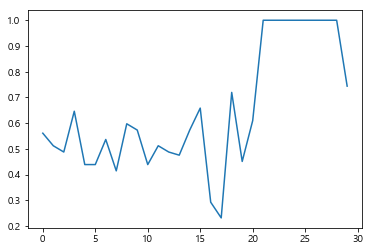

In [205]:
plt.plot(np.diag(p.T))